
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 長短期記憶 (LSTM)

 :ラベル: `sec_lstm`

最初の Elman スタイル RNN が逆伝播 (:cite: `elman1990finding`を使用して訓練された直後、長期的な依存関係の学習の問題 (勾配の消失と爆発による) が顕著になり、Bengio と Hochreiter がこの問題について議論しました (:cite: `bengio1994learning,Hochreiter.Bengio.Frasconi.ea.2001` 。ホッホライターは 1991 年の修士論文の時点でこの問題を明確に述べていましたが、論文はドイツ語で書かれていたため、結果は広く知られていませんでした。グラデーション クリッピングは爆発するグラデーションには役立ちますが、消滅するグラデーションを処理するには、より複雑なソリューションが必要になるようです。勾配消失に対処するための最初で最も成功した手法の 1 つは、:citet: `Hochreiter.Schmidhuber.1997`による長期短期記憶 (LSTM) モデルの形で提供されました。 LSTM は標準的なリカレント ニューラル ネットワークに似ていますが、ここでは通常のリカレント ノードがそれぞれ*メモリ セル*に置き換えられています。各メモリ セルには*内部状態*、つまり固定重み 1 の自己接続リカレント エッジを持つノードが含まれており、勾配が消失または爆発することなく多くのタイム ステップを通過できることが保証されます。

 「長期短期記憶」という用語は、次のような直観から来ています。単純なリカレント ニューラル ネットワークは、重みの形で*長期記憶*を持っています。重みはトレーニング中にゆっくりと変化し、データに関する一般的な知識をエンコードします。また、各ノードから後続のノードに渡される、一時的な活性化の形で*短期記憶も*持っています。 LSTM モデルでは、メモリ セルを介した中間タイプのストレージが導入されています。メモリ セルは、乗算ノードを新たに組み込んだ、特定の接続パターンの単純なノードから構築された複合ユニットです。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## ゲート型メモリセル

各メモリ セルには、*内部状態*と、(i) 特定の入力が内部状態に影響を与えるか (*入力ゲート*)、(ii) 内部状態を $0$ にフラッシュするか (*忘れ*(iii) 特定のニューロンの内部状態*が*セルの出力 (*出力*ゲート) に影響を与えることを許可する必要があります。

### ゲートされた隠し状態

バニラ RNN と LSTM の主な違いは、後者が隠れ状態のゲートをサポートしていることです。これは、非表示状態をいつ*更新する*必要があるか、またいつ*リセットする*必要があるかについて専用のメカニズムがあることを意味します。これらのメカニズムは学習されており、上記の懸念事項に対処します。たとえば、最初のトークンが非常に重要である場合、最初の観察後に隠れた状態を更新しないことを学習します。同様に、無関係な一時的な観察をスキップすることも学びます。最後に、必要なときにいつでも潜在状態をリセットする方法を学びます。これについては以下で詳しく説明します。

### 入力ゲート、フォーゲットゲート、出力ゲート

LSTM ゲートに入力されるデータは、 :numref: `fig_lstm_0`に示すように、現在のタイム ステップの入力と前のタイム ステップの隠れた状態です。シグモイド活性化関数を備えた 3 つの完全に接続された層が、入力ゲート、忘却ゲート、および出力ゲートの値を計算します。シグモイドのアクティブ化の結果、3 つのゲートの値はすべて $(0, 1)$ の範囲内になります。さらに、*入力ノード が*必要です。これは通常、 *tanh*活性化関数で計算されます。*入力ゲートは*、入力ノードの値のどれだけを現在のメモリ セルの内部状態に追加する必要があるかを直感的に決定します。*フォーゲット ゲートは、*メモリの現在の値を保持するかフラッシュするかを決定します。そして、*出力ゲートは*、メモリ セルが現在のタイム ステップでの出力に影響を与えるべきかどうかを決定します。 

![](../img/lstm-0.svg) :ラベル: `fig_lstm_0`

数学的には、$h$ の隠れユニットがあり、バッチ サイズが $n$、入力数が $d$ であるとします。したがって、入力は $\mathbf{X *} t \in \mathbb{R}^{n \times d}$ で、前のタイム ステップの隠れ状態は $\mathbf{H} {* t-1} \in となります。 \mathbb{R}^{n \times h}$。同様に、タイム ステップ $t$ のゲートは次のように定義されます。入力ゲートは $\mathbf{I}_t \in \mathbb{R}^{n \times h}$、忘却ゲートは $\mathbf{ F}_t \in \mathbb{R}^{n \times h}$、出力ゲートは $\mathbf{O}_t \in \mathbb{R}^{n \times h}$ です。それらは次のように計算されます。

 $$ \begin{aligned} \mathbf{I} *t &amp;= \sigma(\mathbf{X}_t \mathbf{W}* {xi} + \mathbf{H} *{t-1} \mathbf{W} {*こんにちは} + \mathbf{b} *i),\ \mathbf{F}_t &amp;= \sigma(\mathbf{X}_t \mathbf{W} {* xf} + \mathbf{H} *{t-1} \mathbf{ W}* {hf} + \mathbf{b} *f),\ \mathbf{O}_t &amp;= \sigma(\mathbf{X}_t \mathbf{W} {* xo} + \mathbf{H} *{t-1 } \mathbf{W}* {ho} + \mathbf{b}_o)、\end{aligned} $$

ここで、$\mathbf{W} *{xi}、\mathbf{W}* {xf}、\mathbf{W} *{xo} \in \mathbb{R}^{d \times h}$ および $\mathbf{W}* {hi}、\mathbf{W} *{hf}、\mathbf{W}* {ho} \in \mathbb{R}^{h \times h}$ は重みパラメータであり、$\mathbf{b}_i、\mathbf {b}_f、\mathbf{b}_o \in \mathbb{R}^{1 \times h}$ はバイアス パラメーターです。ブロードキャスト ( :numref: `subsec_broadcasting`参照) が合計中にトリガーされることに注意してください。シグモイド関数 ( :numref: `sec_mlp`で導入) を使用して、入力値を区間 $(0, 1)$ にマッピングします。

### 入力ノード

次にメモリセルを設計します。さまざまなゲートのアクションをまだ指定していないため、最初に*入力ノード*$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$ を導入します。その計算は上記の 3 つのゲートの計算と似ていますが、活性化関数として $(-1, 1)$ の値の範囲を持つ $\tanh$ 関数を使用します。これにより、タイム ステップ $t$ では次の方程式が導かれます。

 $$\チルデ{\mathbf{C}} *t = \text{tanh}(\mathbf{X}_t \mathbf{W}* {xc} + \mathbf{H} *{t-1} \mathbf{W}* { hc} + \mathbf{b}_c),$$

ここで $\mathbf{W} *{xc} \in \mathbb{R}^{d \times h}$ と $\mathbf{W}* {hc} \in \mathbb{R}^{h \times h}$は重みパラメータ、$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ はバイアス パラメータです。

入力ノードの簡単な図を :numref: `fig_lstm_1`に示します。

![](../img/lstm-1.svg) :ラベル: `fig_lstm_1`

### メモリセルの内部状態

*LSTM では、入力ゲート $\mathbf{I} t$ は $\tilde{\mathbf{C}}_t$ を介して新しいデータをどの程度考慮するかを制御し、忘却ゲート $\mathbf{F}_t$ はその方法に対処します。古いセルの内部状態 $\mathbf{C} {t-1} \in \mathbb{R}^{n \times h}$ の多くは*保持されます。アダマール (要素ごと) 積演算子 $\odot$ を使用すると、次の更新方程式が得られます。

 $$\mathbf{C} *t = \mathbf{F}_t \odot \mathbf{C}* {t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

忘却ゲートが常に 1 で、入力ゲートが常に 0 の場合、メモリ セルの内部状態 $\mathbf{C}_{t-1}$ は永久に一定のままとなり、後続の各タイム ステップに変更されずに渡されます。ただし、入力ゲートと忘却ゲートにより、この値をいつ変更しないようにするか、後続の入力に応じていつ摂動するかをモデルに学習する柔軟性が与えられます。実際には、この設計により勾配消失の問題が軽減され、特に長いシーケンス長のデータセットに直面した場合に、モデルのトレーニングがはるかに容易になります。

したがって、 :numref: `fig_lstm_2`のフロー図に到達します。 

![](../img/lstm-2.svg)

 :ラベル: `fig_lstm_2`

### 隠れた状態

最後に、メモリ セルの出力、つまり他の層から見える隠れ状態 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ を計算する方法を定義する必要があります。ここで出力ゲートが登場します。 LSTM では、まず $\tanh$ をメモリ セルの内部状態に適用し、次に今度は出力ゲートを使用して別の点単位の乗算を適用します。これにより、$\mathbf{H}_t$ の値が常に $(-1, 1)$ の範囲内に収まるようになります。

 $$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

出力ゲートが 1 に近い場合は常に、メモリ セルの内部状態が後続の層に無制限に影響を与えることを許可します。一方、出力ゲート値が 0 に近い場合、現在のタイム ステップで現在のメモリがネットワークの他の層に影響を与えるのを防ぎます。メモリ セルは、ネットワークの残りの部分に影響を与えることなく (出力ゲートが 0 に近い値をとる限り) 多くのタイム ステップにわたって情報を蓄積することができ、その後、出力ゲートがオンになるとすぐに、後続のタイム ステップで突然ネットワークに影響を与えることに注意してください。 0 に近い値から 1 に近い値に反転します。

 :numref: `fig_lstm_3`は、データ フローの図が示されています。

![](../img/lstm-3.svg) :ラベル: `fig_lstm_3`

## ゼロからの実装

次に、LSTM を最初から実装してみましょう。 :numref: `sec_rnn-scratch`の実験と同じように、最初に*Time Machine*データセットを読み込みます。

###  [**モデルパラメータの初期化**]

次に、モデルパラメータを定義して初期化する必要があります。前と同様に、ハイパーパラメータ`num_hiddens`非表示ユニットの数を指定します。標準偏差 0.01 のガウス分布に従って重みを初期化し、バイアスを 0 に設定します。


In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node


[**実際のモデル**] は上記のように定義され、3 つのゲートと 1 つの入力ノードで構成されます。非表示状態のみが出力層に渡されることに注意してください。


In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)


### [**トレーニング**] と予測

:numref: `sec_rnn-scratch`で紹介されているように`RNNLMScratch`クラスをインスタンス化して、LSTM モデルをトレーニングしましょう。


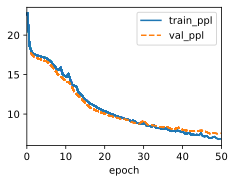

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


## [**簡潔な実装**]

高レベル API を使用すると、LSTM モデルを直接インスタンス化できます。これには、上で明示したすべての構成の詳細がカプセル化されています。以前に詳しく説明した多くの詳細について、Python ではなくコンパイルされた演算子を使用するため、コードは大幅に高速になります。


In [5]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

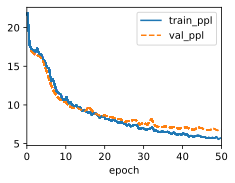

In [6]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'


LSTM は、非自明な状態制御を備えた典型的な潜在変数自己回帰モデルです。多層、残留接続、さまざまな種類の正則化など、長年にわたってその多くの変形が提案されてきました。ただし、LSTM およびその他のシーケンス モデル (GRU など) のトレーニングは、シーケンスの長距離依存性により非常にコストがかかります。後で、場合によっては使用できるトランスフォーマーなどの代替モデルに遭遇します。

## まとめ

LSTM は 1997 年に公開されましたが、2000 年代半ばの予測コンテストでいくつかの勝利を収めたことでさらに有名になり、2011 年から最近まで、2017 年に始まった Transformer モデルの台頭により、シーケンス学習の主要なモデルとなりました。彼らの重要なアイデアの一部は、LSTM によって導入されたアーキテクチャ設計の革新によるものです。 LSTM には、情報の流れを制御する入力ゲート、忘却ゲート、出力ゲートの 3 種類のゲートがあります。 LSTM の隠れ層出力には、隠れ状態とメモリ セルの内部状態が含まれます。メモリセルの内部状態は完全に内部状態ですが、隠れ状態のみが出力層に渡されます。 LSTM は、勾配の消失と爆発を軽減できます。

## 演習
1. ハイパーパラメータを調整し、実行時間、複雑さ、出力シーケンスに対するそれらの影響を分析します。
1. 文字列ではなく適切な単語を生成するには、モデルをどのように変更する必要があるでしょうか?
1. 特定の隠れディメンションに対する GRU、LSTM、および通常の RNN の計算コストを比較します。トレーニングと推論のコストに特に注意してください。
1. 候補メモリ セルは $\tanh$ 関数を使用して値の範囲が $-1$ と $1$ の間であることを保証しているのに、出力値の範囲を保証するために隠れ状態で $\tanh$ 関数を再度使用する必要があるのはなぜでしょうか。 $-1$ と $1$ の間ですか?
1. 文字列予測ではなく、時系列予測用の LSTM モデルを実装します。



[ディスカッション](https://discuss.d2l.ai/t/1057)
